# Cooling of the oceanic lithosphere

**Goal:** Implement the half-space cooling model and compare its predictions to observations of heat flow, lithosphere age, and bathymetry.

The half-space cooling model simulates the cooling of the oceanic lithosphere as it moves away from the mid-ocean ridges where it's formed (due to  seafloor spreading).

<img style="width: 700px; margin: 10px auto;" src="https://raw.githubusercontent.com/leouieda/lithosphere/bb86251c0934b0df98c32181788fdc76472aa4b5/lectures/assets/halfspace-model-time.svg">
<p style="text-align: left; width: 700px; max-width: 100%; margin: 30px auto;">
Figure caption: Sketch of the half-space cooling model setup. The lithosphere-asthenosphere boundary (LAB) is marked by an isotherm. The ridge is at the origin and the plates spread symmetrically with constant velocity $u$.
</p>

The cooling happens by vertical condution of heat to the water layer and can be modelled by the 1D diffusion equation:

$$
\dfrac{\partial^2 T}{\partial z^2}
= \dfrac{1}{\alpha} \dfrac{\partial T}{\partial t}
$$


The solution to this equation, given the starting condition of the temperature being equal to the asthenosphere temperature $T(z, t=0) = T_a$ and boundary condition of the temperature at the surface being constant $T(z=0, t) = T_0$, is:

$$
T(z, t) = T_0 + (T_a - T_0)\ \text{erf}
\left(
\dfrac{z}{2\sqrt{\alpha t}}
\right)
$$

in which $\alpha$ is the thermal diffusivity of the lithosphere, $t$ is the age of the lithosphere, $z$ is the depth, and $\text{erf}$ is the error function.

From this equation, we can apply Fourier's law to get **heat flow at the surface**:

$$
\ q_0(t) = k \dfrac{T_a - T_0}{\sqrt{\pi \alpha t}}
$$

where $k$ is the thermal conductivity of the lithosphere.

We can also apply the conditions for isostatic equilibrium (since we know that the oceanic lithosphere is largely in equilibrium from gravity disturbance data) to predict **bathymetry** from the half-space cooling model:

$$
w(t) = w_r + \dfrac{2 \rho_a \alpha_V (T_a - T_0)}{\rho_a - \rho_w}
\sqrt{\dfrac{\alpha t}{\pi}}
$$

in which $w_r$ is the bathymetric depth at the ridge, $\rho_a$ is the density of the asthenosphere, $\rho_w$ is the density of water, and $\alpha_V$ is the coefficient of thermal expansion of the lithosphere.

**Our job now is to code the equations for bathymetry and surface heat flow in Python**.

## Import the required libraries

Load the required software to load the data, make maps, and perform calculations.

In [1]:
# For arrays and linear algebra
import numpy as np
# To make figures and maps
import matplotlib.pyplot as plt
import xarray as xr

## Load the data grids

In [4]:
data = xr.load_dataset("global-geophysical-data.nc")
data

<xarray.Dataset>
Dimensions:              (latitude: 901, longitude: 1800)
Coordinates:
  * latitude             (latitude) float32 -90.0 -89.8 -89.6 ... 89.6 89.8 90.0
  * longitude            (longitude) float32 -180.0 -179.8 ... 179.6 179.8
    height               (latitude, longitude) float32 2.716e+03 ... 15.47
Data variables:
    gravity_disturbance  (latitude, longitude) float32 -27.21 -27.21 ... 24.71
    gravity_bouguer      (latitude, longitude) float32 -331.2 -331.2 ... 312.6
    topography_smoothed  (latitude, longitude) float32 2.796e+03 ... -3.56e+03
    topography           (latitude, longitude) float32 2.716e+03 ... -4.213e+03
    heat_flow            (latitude, longitude) float32 75.2 75.2 ... 84.7 84.7
    lithosphere_age      (latitude, longitude) float32 nan nan ... 55.46 55.46

In [54]:
pacific = data.sel(longitude=slice(-170, -100), latitude=slice(-70, -18))#.coarsen(longitude=3, latitude=3, boundary='trim').median()
pacific

<xarray.Dataset>
Dimensions:              (latitude: 261, longitude: 351)
Coordinates:
  * latitude             (latitude) float32 -70.0 -69.8 -69.6 ... -18.2 -18.0
  * longitude            (longitude) float32 -170.0 -169.8 ... -100.2 -100.0
    height               (latitude, longitude) float32 -62.98 -63.0 ... -4.596
Data variables:
    gravity_disturbance  (latitude, longitude) float32 -62.59 -58.97 ... -1.69
    gravity_bouguer      (latitude, longitude) float32 227.7 226.6 ... 276.3
    topography_smoothed  (latitude, longitude) float32 -4.17e+03 ... -4.125e+03
    topography           (latitude, longitude) float32 -4.247e+03 ... -4.068e+03
    heat_flow            (latitude, longitude) float32 61.8 61.8 ... 107.9 109.4
    lithosphere_age      (latitude, longitude) float32 74.22 74.19 ... 14.53

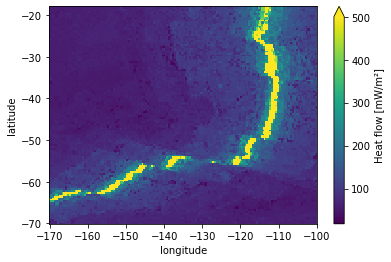

In [55]:
pacific.heat_flow.plot(vmax=500)

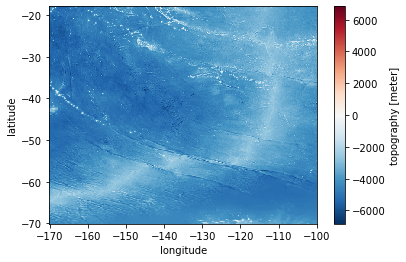

In [56]:
pacific.topography.plot()

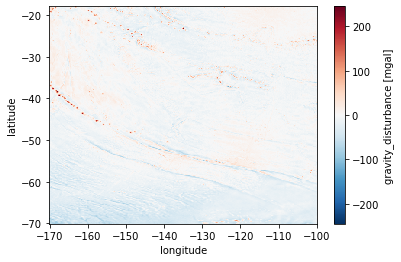

In [57]:
pacific.gravity_disturbance.plot()

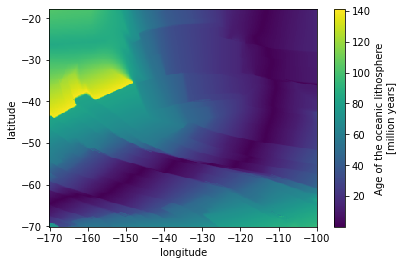

In [58]:
pacific.lithosphere_age.plot()

In [59]:
def halfspace_heat(age, surface_temperature, asthenosphere_temperature, diffusivity, conductivity):
    """
    Heat flow from the half space cooling model.
    
    Parameters
    ----------
    age
        Lithosphere age in million years.
    surface_temperature
        Temperature of the surface boundary condition in K. 
    asthenosphere_temperature
        Temperature of the asthenosphere used as an initial condition in K.
    diffusivity
        Thermal diffusivity in mm²/s.
    conductivity
        Thermal conductivity in W/mK.
    
    Returns
    -------
    heat_flow
        Model heat flow at the surface in mW/m².
    """
    # 1000 converts from W to mW (miliWatts)
    # 1e-6 converts from mm² to m²
    # 31557600000000 converts from Myr to seconds
    flow = 1000 * conductivity * (asthenosphere_temperature - surface_temperature) / (
        np.sqrt(np.pi * 1e-6 * diffusivity * age * 31557600000000)
    )
    return flow

In [60]:
flow_halfspace = halfspace_heat(pacific.lithosphere_age, surface_temperature=273, asthenosphere_temperature=1573, diffusivity=1, conductivity=3.3)

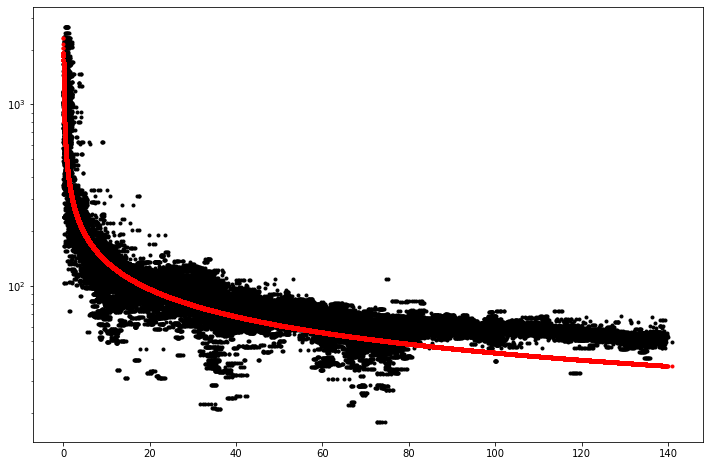

In [61]:
plt.figure(figsize=(12, 8))
plt.plot(pacific.lithosphere_age.values.ravel(), pacific.heat_flow.values.ravel(), ".k")
plt.plot(pacific.lithosphere_age.values.ravel(), flow_halfspace.values.ravel(), ".r")
plt.yscale("log")

In [62]:
def bathymetry_halfspace(age, ridge_depth, density_mantle, density_water, temperature_mantle, temperature_surface, thermal_expansion, diffusivity):
    "Predict bathymetry from the half-space cooling model"
    bathymetry = (
        # Convert from km to m
        ridge_depth * 1e3
        + 2 * density_mantle * thermal_expansion * (temperature_mantle - temperature_surface) / (
            density_mantle - density_water
            # Convert diffusivity from mm²/s to m²/s
            # Convert the age from Myr to s
        ) * np.sqrt(diffusivity * 1e-6 *  age * 31557600000000 / np.pi)
    )
    # -1 because the equation gives us thickness of the water layer
    return -1 * bathymetry    

In [78]:
pacific_coarse = pacific.coarsen(longitude=6, latitude=6, boundary="trim").median()
pacific_coarse

<xarray.Dataset>
Dimensions:              (latitude: 43, longitude: 58)
Coordinates:
  * latitude             (latitude) float32 -69.5 -68.3 -67.1 ... -20.3 -19.1
  * longitude            (longitude) float32 -169.5 -168.3 ... -102.3 -101.1
    height               (latitude, longitude) float32 -62.09 -61.74 ... -3.754
Data variables:
    gravity_disturbance  (latitude, longitude) float32 -63.41 -66.44 ... 1.507
    gravity_bouguer      (latitude, longitude) float32 226.4 230.2 ... 286.3
    topography_smoothed  (latitude, longitude) float32 -4.169e+03 ... -4.133e+03
    topography           (latitude, longitude) float32 -4.249e+03 ... -4.174e+03
    heat_flow            (latitude, longitude) float32 62.45 106.8 ... 118.2
    lithosphere_age      (latitude, longitude) float32 74.11 29.46 ... 13.2

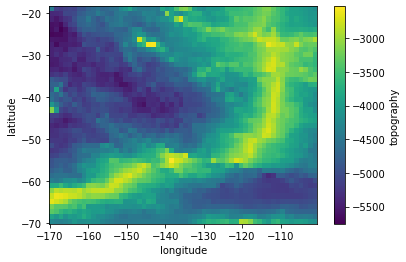

In [81]:
pacific_coarse.topography.plot()

In [79]:
bathy_halfspace = bathymetry_halfspace(
    pacific_coarse.lithosphere_age,
    ridge_depth=2.5,
    density_mantle=3300,
    density_water=1000,
    temperature_mantle=1600,
    temperature_surface=273,
    thermal_expansion=3e-5,
    diffusivity=1,
)

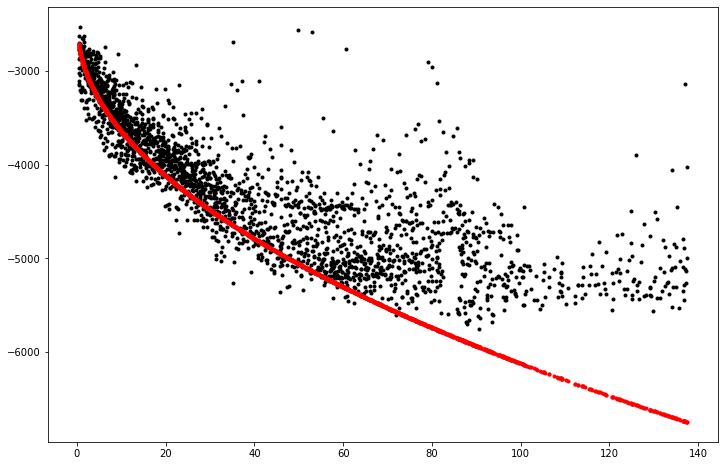

In [82]:
plt.figure(figsize=(12, 8))
plt.plot(pacific_coarse.lithosphere_age.values.ravel(), pacific_coarse.topography.values.ravel(), ".k")
plt.plot(pacific_coarse.lithosphere_age.values.ravel(), bathy_halfspace.values.ravel(), ".r")
